In [7]:
import os
from typing import Optional

import matplotlib.dates as mdates
import pandas as pd
from matplotlib import axes, pyplot as plt
from matplotlib.ticker import MultipleLocator


class Simulation:
    def __init__(
            self,
            name: str,
            predictions: pd.DataFrame,
            violations: pd.DataFrame,
            intervals: list[tuple[pd.Timestamp, pd.Timestamp]],
            color: str,
            violation_color: Optional[str] = None
    ):
        self.name = name
        self.predictions = predictions
        self.violations = violations
        self.color = color
        self.violation_color = violation_color if violation_color is not None else color
        self.intervals = intervals


def plot_simulations(
        start_date: pd.Timestamp,
        end_date: pd.Timestamp,
        measurements: pd.DataFrame,
        simulations: list[Simulation],
        threshold: float,
        name: str,
        figsize: tuple[int, int] = (20, 5),
        locator=mdates.HourLocator(interval=2)
):
    fig, plots = plt.subplots(
        figsize=figsize,
        dpi=300
    )
    plots: axes.Axes

    markers = ["o", "s", "d", "x", "*"]

    m = measurements.loc[start_date:end_date]

    # Measurements
    plots.plot(m.index, m['TL'], label='Measurements', zorder=5, color='black')

    # Threshold
    plots.plot(m.index, m['TL'] + threshold, label='_Measurements (upper threshold)',
               color='gray', linestyle='dashed')
    plots.plot(m.index, m['TL'] - threshold, label='_Measurements (lower threshold)',
               color='gray', linestyle='dashed')
    plt.fill_between(
        m.index, m['TL'] - threshold, m['TL'] + threshold,
        color='gray', alpha=0.2, label=f'Threshold (±{threshold}°C)'
    )

    i = 0

    violations_log = []
    hide_name = (len(simulations) == 1)

    # Predictions
    for simulation in simulations:
        first_plot = True
        for interval in simulation.intervals:
            start, end = interval
            predictions = simulation.predictions.loc[start:end]
            p_label = 'Predictions'
            if not hide_name:
                p_label += f' ({simulation.name})'
            if not first_plot:
                p_label = f"_{p_label}"
            plots.plot(predictions.index, predictions['TL'], label=p_label, zorder=6, color=simulation.color)

            # Violations
            violations = simulation.violations.loc[start:end]
            violations_log += violations.index.tolist()
            print(f"{simulation.name}={len(violations)}/{len(simulation.violations)}")
            nearest_indices = predictions.index.get_indexer(violations.index, method='nearest')
            violation_predictions = predictions.iloc[nearest_indices]
            v_label = f'Violations'
            if not hide_name:
                v_label += f' ({simulation.name})'
            if not first_plot:
                v_label = f"_{v_label}"
            plots.scatter(violation_predictions.index, violation_predictions['TL'],
                          label=v_label, s=12, zorder=8, color=simulation.violation_color, marker=markers[i])

            first_plot = False

        # Horizon updates
        # nearest_indices = predictions.index.get_indexer(horizon_updates.index, method='nearest')
        # horizon_updates_predictions = predictions.iloc[nearest_indices]
        # plots.scatter(horizon_updates_predictions.index,
        #               horizon_updates_predictions['TL'], label='Horizon Update', s=12, zorder=8, color='limegreen',
        #               marker='8')

        # Configuration updates
        # configs = configuration_updates.copy()
        # configs.loc[measurements.index.min()] = configuration_updates.iloc[0] if last_config is None else last_config
        # configs.loc[measurements.index.max()] = configuration_updates.iloc[-1] if len(
        #     configuration_updates) > 0 else configs.iloc[-1]
        # configs.sort_index(inplace=True)
        i += 1

    new_labels = []
    patches = []

    print(f"Total violations = {len(set(violations_log))}")

    plots.xaxis.set_major_locator(locator)
    plots.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plots.yaxis.set_major_locator(MultipleLocator(5))
    plt.xticks(rotation=90)
    plots.margins(x=0.01, y=0.01)

    plots.grid(True)
    # plots.set_title('Simulation')
    plots.set_ylabel('Temperature (°C)', fontsize=20)
    handles, labels = plots.get_legend_handles_labels()
    plt.legend(handles=handles + patches, labels=labels + new_labels, loc='best')

    # plt.xlabel(fontsize=18)  # Dimensione del font dell'asse X
    # plt.ylabel(fontsize=18)  # Dimensione del font dell'asse Y

    # Legenda
    plt.legend(fontsize=18)  # Dimensione del font della legenda

    # Tick degli assi
    plt.xticks(fontsize=15)  # Dimensione del font dei tick dell'asse X
    plt.yticks(fontsize=15)  # Dimensione del font dei tick dell'asse Y

    file_path = os.path.join("analysis", "charts", "plots", f"{name}.png")
    fig.savefig(file_path, format='png', bbox_inches='tight')
    plt.show()
    plt.close()


def load_simulation(
        id: str,
        intervals: list[(pd.Timestamp, pd.Timestamp)],
        color: str,
        violation_color: Optional[str] = None
) -> Simulation:
    folder = os.path.join("simulations", id)
    predictions = pd.read_csv(f"{folder}/predictions.csv", parse_dates=True, index_col=0)
    violations = pd.read_csv(f"{folder}/violations.csv", parse_dates=True, index_col=0)

    return Simulation(
        name=id,
        predictions=predictions,
        violations=violations,
        color=color,
        violation_color=violation_color,
        intervals=intervals
    )


def calculate_intervals(
        switches: pd.DataFrame,
        start_time: pd.Timestamp,
        end_time: pd.Timestamp,
) -> dict[str, list[tuple[pd.Timestamp, pd.Timestamp]]]:
    model_column = "configuration_id"
    intervals: dict[str, list[tuple[pd.Timestamp, pd.Timestamp]]] = {}

    models = switches.loc[start_time:end_time]
    active_model = models[model_column][0]

    for timestamp, row in models.iterrows():
        model = row[model_column]

        if model != active_model:
            if active_model not in intervals:
                intervals[active_model] = []
            intervals[active_model].append((start_time, timestamp))
            start_time = timestamp
            active_model = model

    if active_model not in intervals:
        intervals[active_model] = []
    intervals[active_model].append((start_time, end_time))

    return intervals



vienna_2019_2019_simple_dense_static_1v1h=51/5858
Total violations = 51


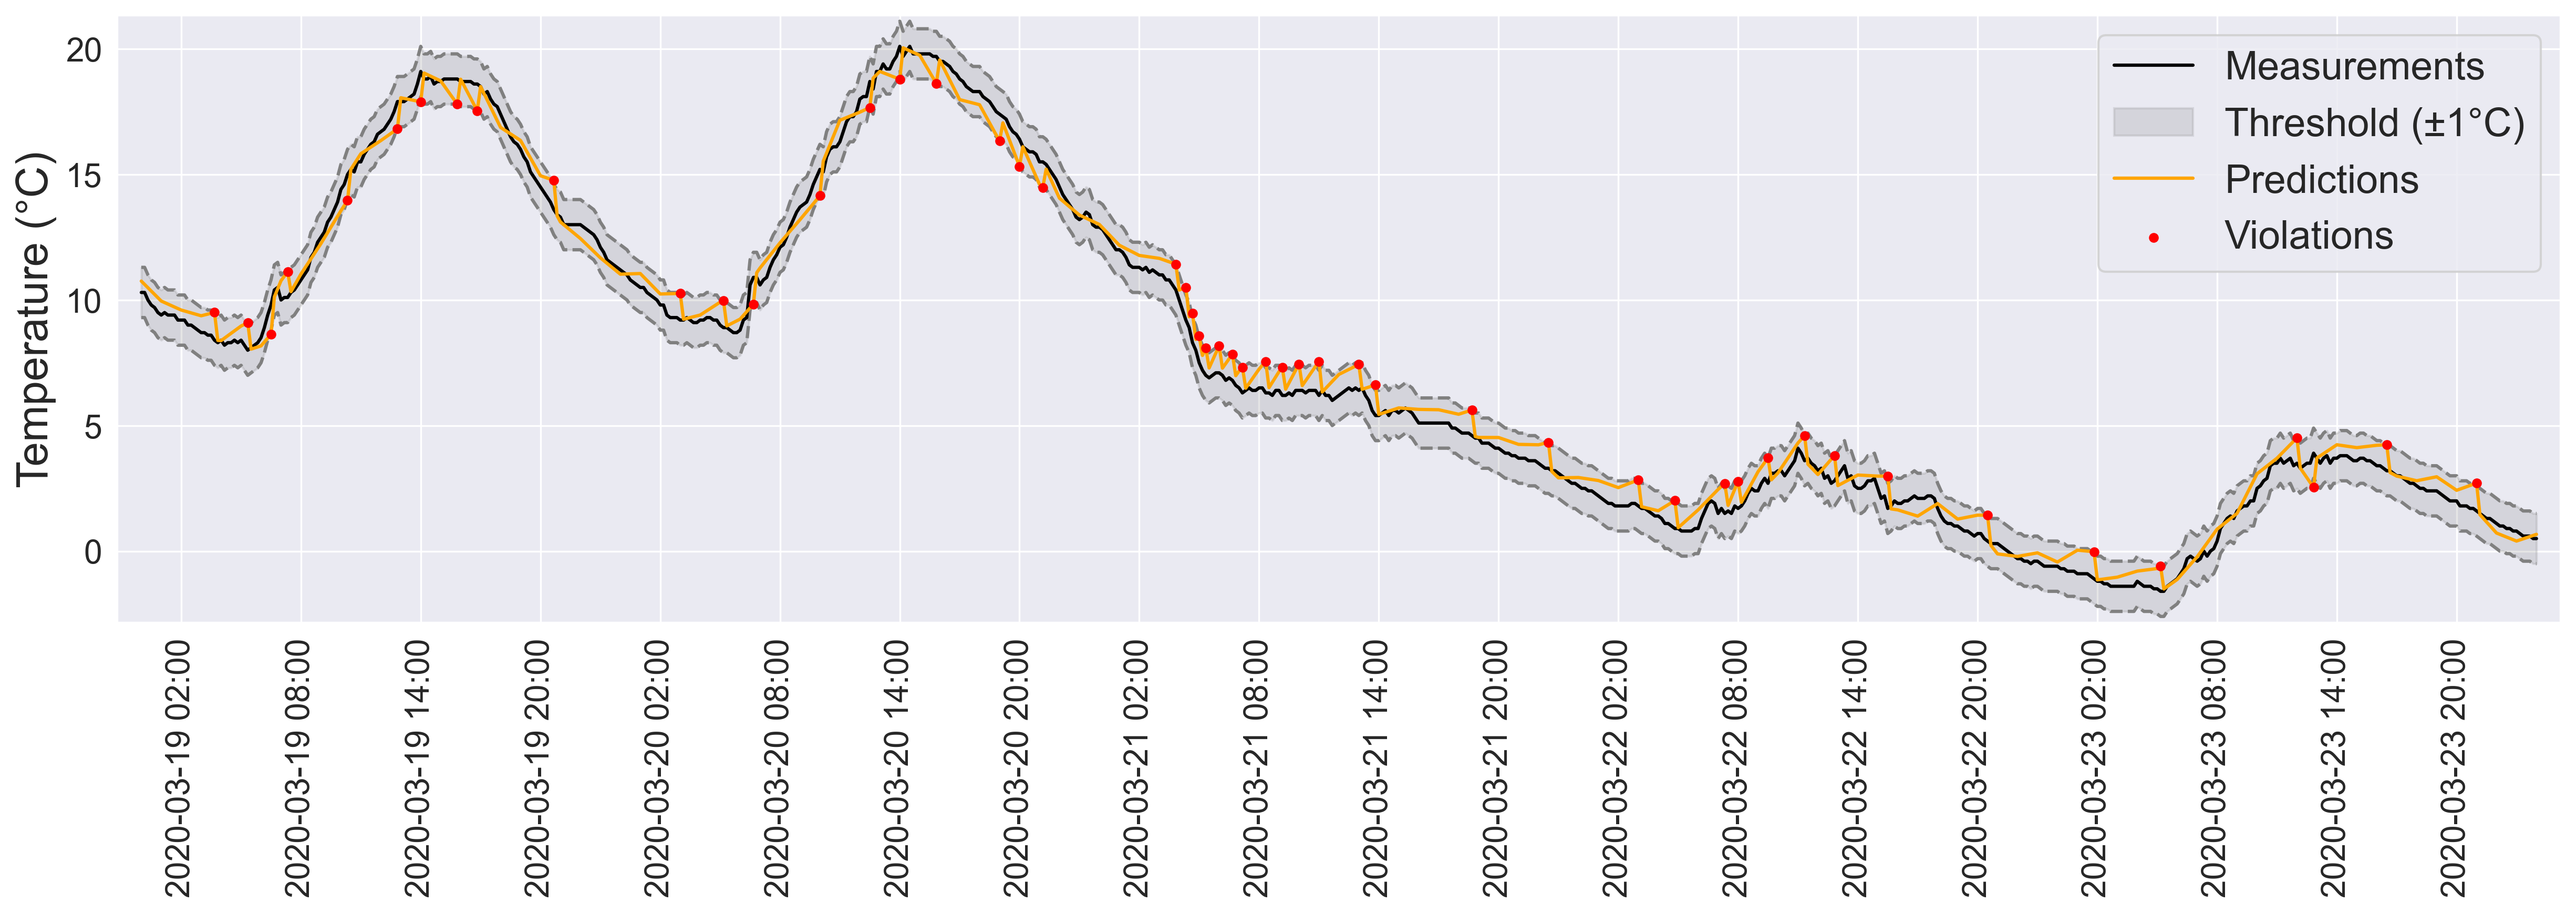

In [8]:
measurements = pd.read_csv("simulations_data/sim_data.csv", parse_dates=True, index_col=0)

colors = [
    '#FF9999', '#66B2FF', '#9900ff', '#FFD700', '#FFA500', '#82B366', '#FF69B4', '#67AB9F', '#994C00', '#666600'
]

start_date = pd.Timestamp(year=2020, month=3, day=19)
end_date = pd.Timestamp(year=2020, month=3, day=24)

full_range_interval = (start_date, end_date)

baseline = load_simulation(
    "vienna_2019_2019_simple_dense_static_1v1h",
    intervals=[full_range_interval],
    color=colors[4],
    violation_color="red"
)

plot_simulations(
    start_date=start_date,
    end_date=end_date,
    measurements=measurements,
    simulations=[baseline],
    threshold=1,
    name="simulation_example",
    locator=mdates.HourLocator(interval=6)
)

vienna_2019_2019_simple_dense_static_1v1h=65/5858
Total violations = 65


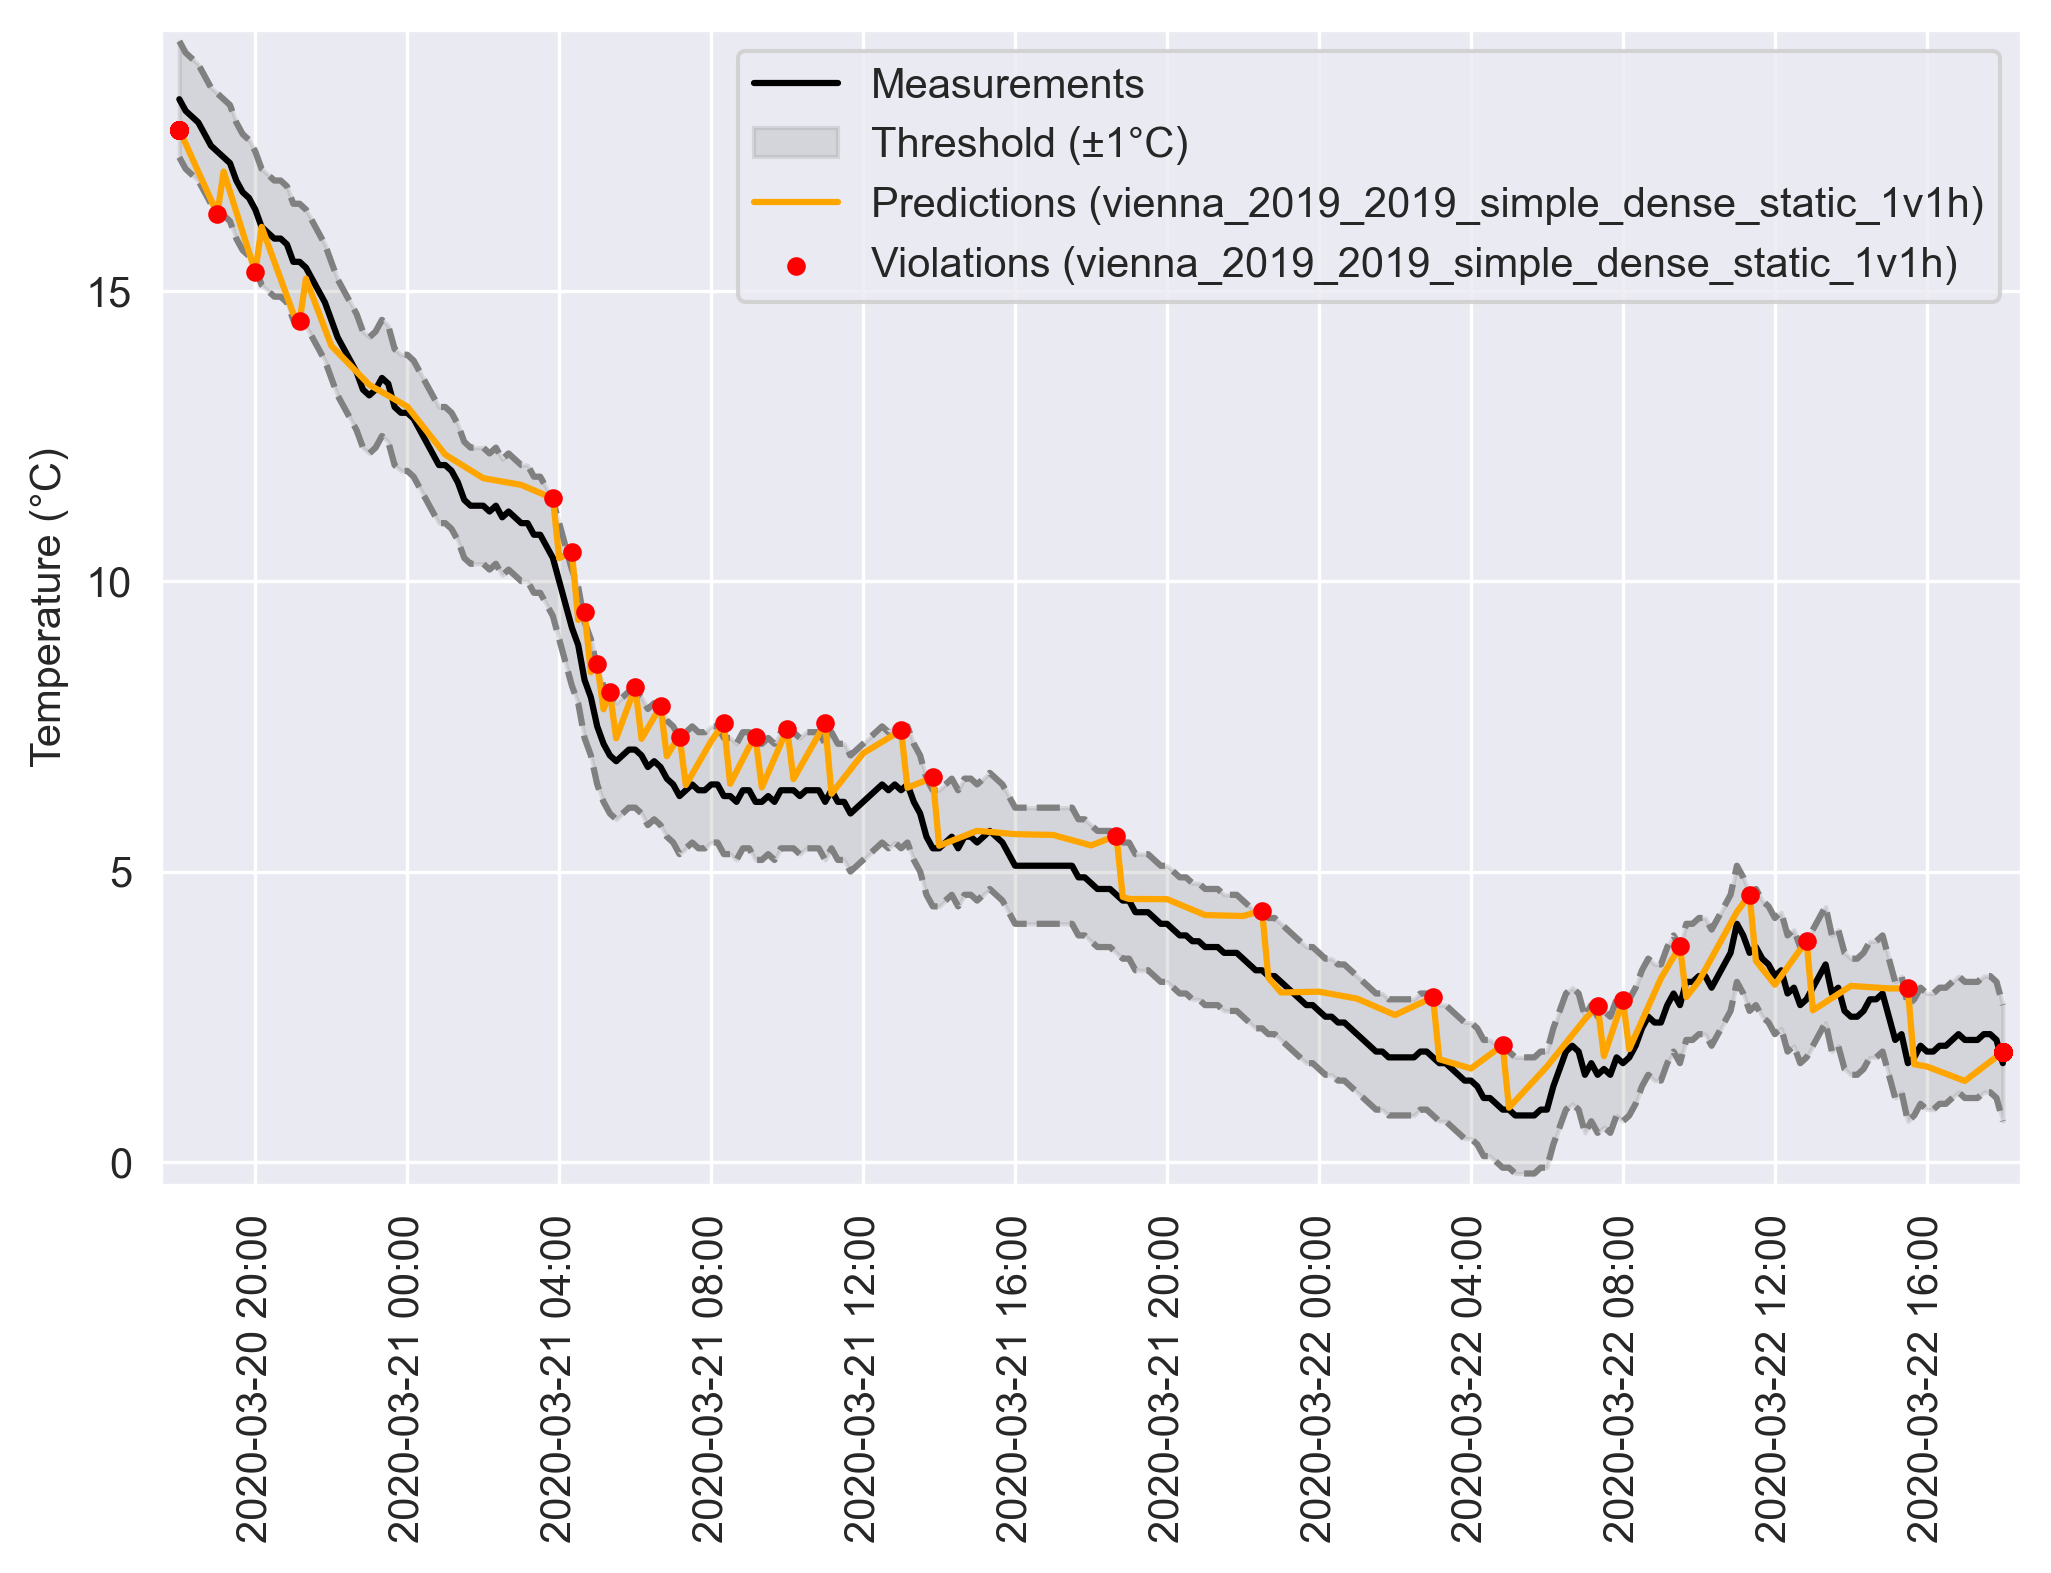

In [46]:
start_date = pd.Timestamp(year=2020, month=3, day=20, hour=18)
end_date = pd.Timestamp(year=2020, month=3, day=22, hour=18)
baseline.predictions = baseline.predictions.loc[start_date:end_date]

plot_simulations(
    start_date=start_date,
    end_date=end_date,
    measurements=measurements,
    simulations=[baseline],
    threshold=1,
    name="simulation_example_zoom",
    locator=mdates.HourLocator(interval=4),
    figsize=(8, 5)
)

linz_2010_2019_simple_lstm_static_1v1h=14/5239
linz_2010_2019_conv_lstm_static_1v1h=14/5563
linz_2010_2019_simple_dense_static_1v1h=15/5291
Total violations = 36


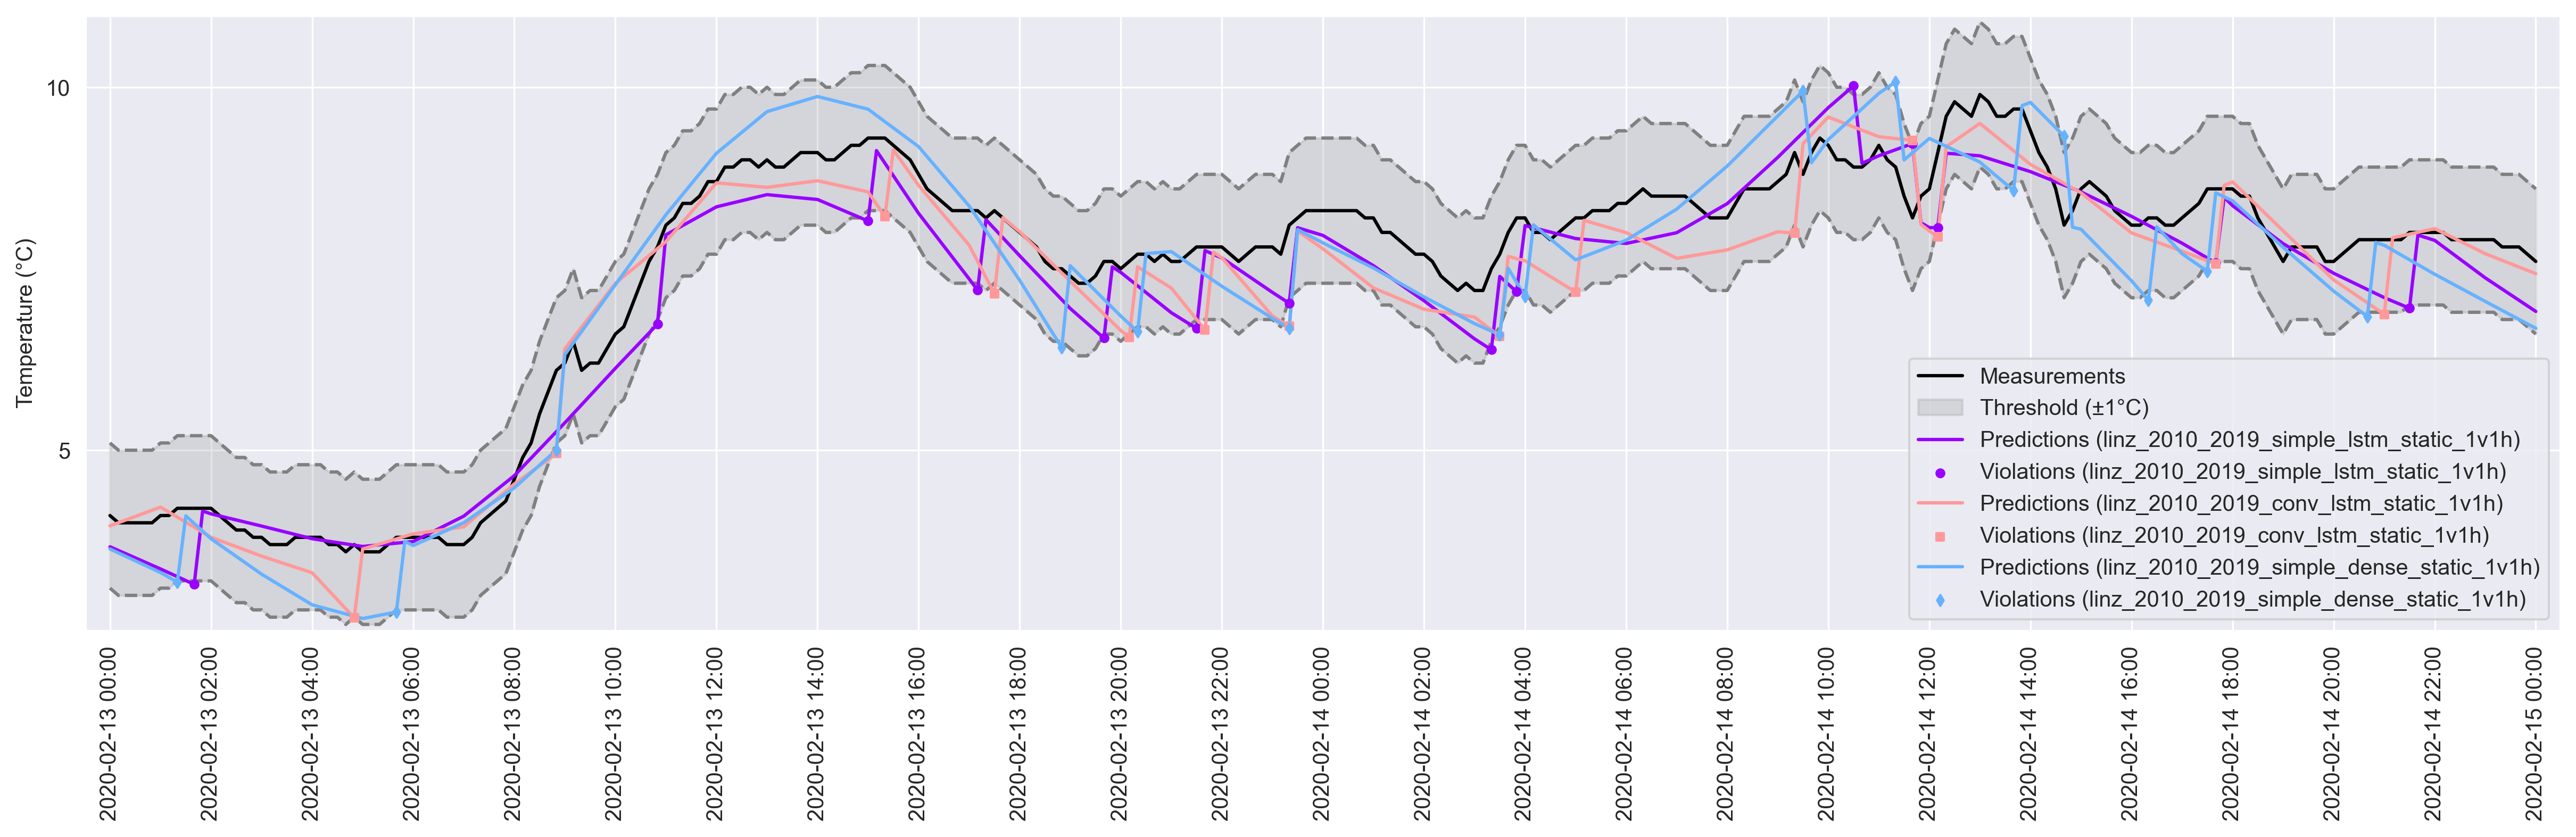

In [47]:
anomaly_start_date = pd.Timestamp(year=2020, month=2, day=13)
anomaly_end_date = pd.Timestamp(year=2020, month=2, day=15)

full_range_interval = (anomaly_start_date, anomaly_end_date)

simple_lstm = load_simulation("linz_2010_2019_simple_lstm_static_1v1h", color=colors[2],
                              intervals=[full_range_interval])
conv_lstm = load_simulation("linz_2010_2019_conv_lstm_static_1v1h", color=colors[0], intervals=[full_range_interval])
simple_dense = load_simulation("linz_2010_2019_simple_dense_static_1v1h", color=colors[1],
                               intervals=[full_range_interval])

plot_simulations(
    start_date=anomaly_start_date,
    end_date=anomaly_end_date,
    measurements=measurements,
    simulations=[simple_lstm, conv_lstm, simple_dense],
    threshold=1,
    name="singe_arch_anomaly"
)

linz_2010_2019_simple_lstm_static_1v1h=14/5239
Total violations = 14


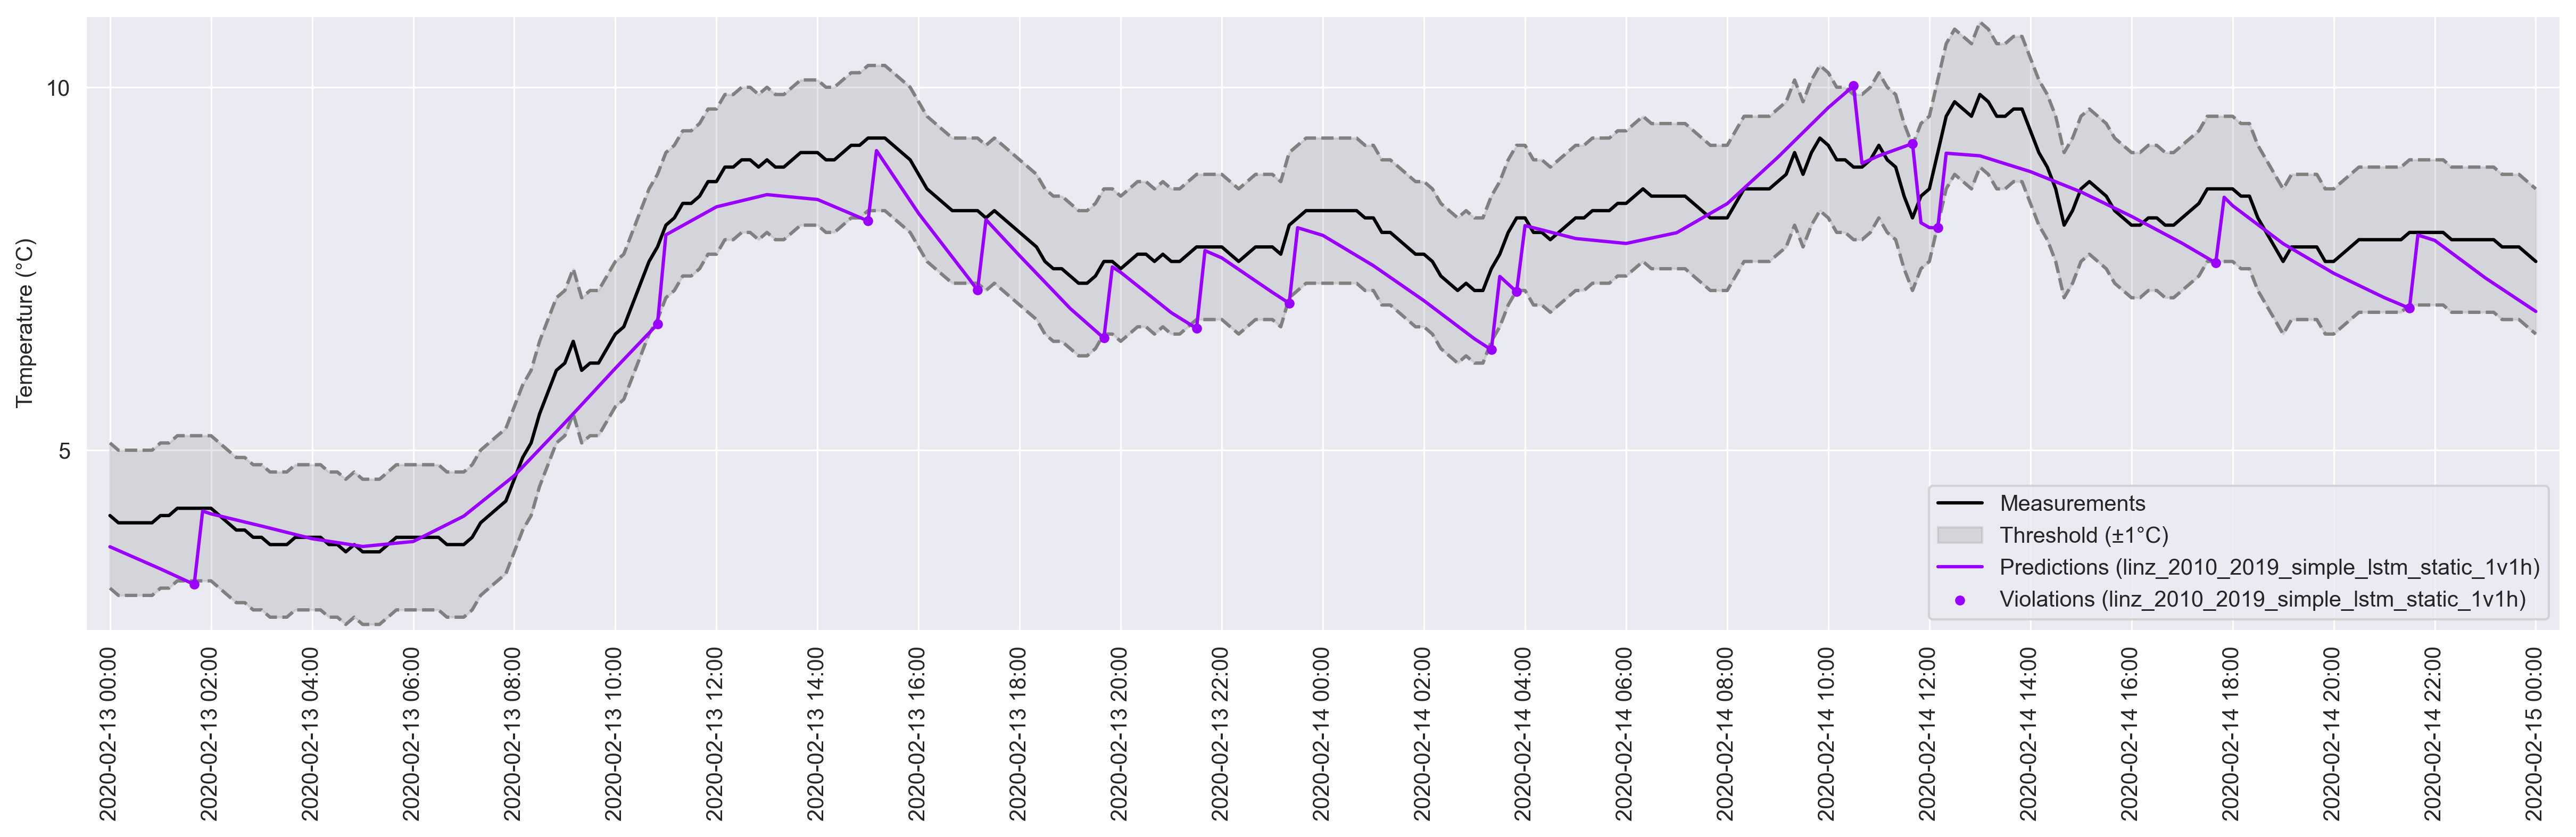

In [48]:
plot_simulations(
    start_date=anomaly_start_date,
    end_date=anomaly_end_date,
    measurements=measurements,
    simulations=[simple_lstm],
    threshold=1,
    name="simple_lstm_anomaly"
)

linz_2010_2019_conv_lstm_static_1v1h=14/5563
Total violations = 14


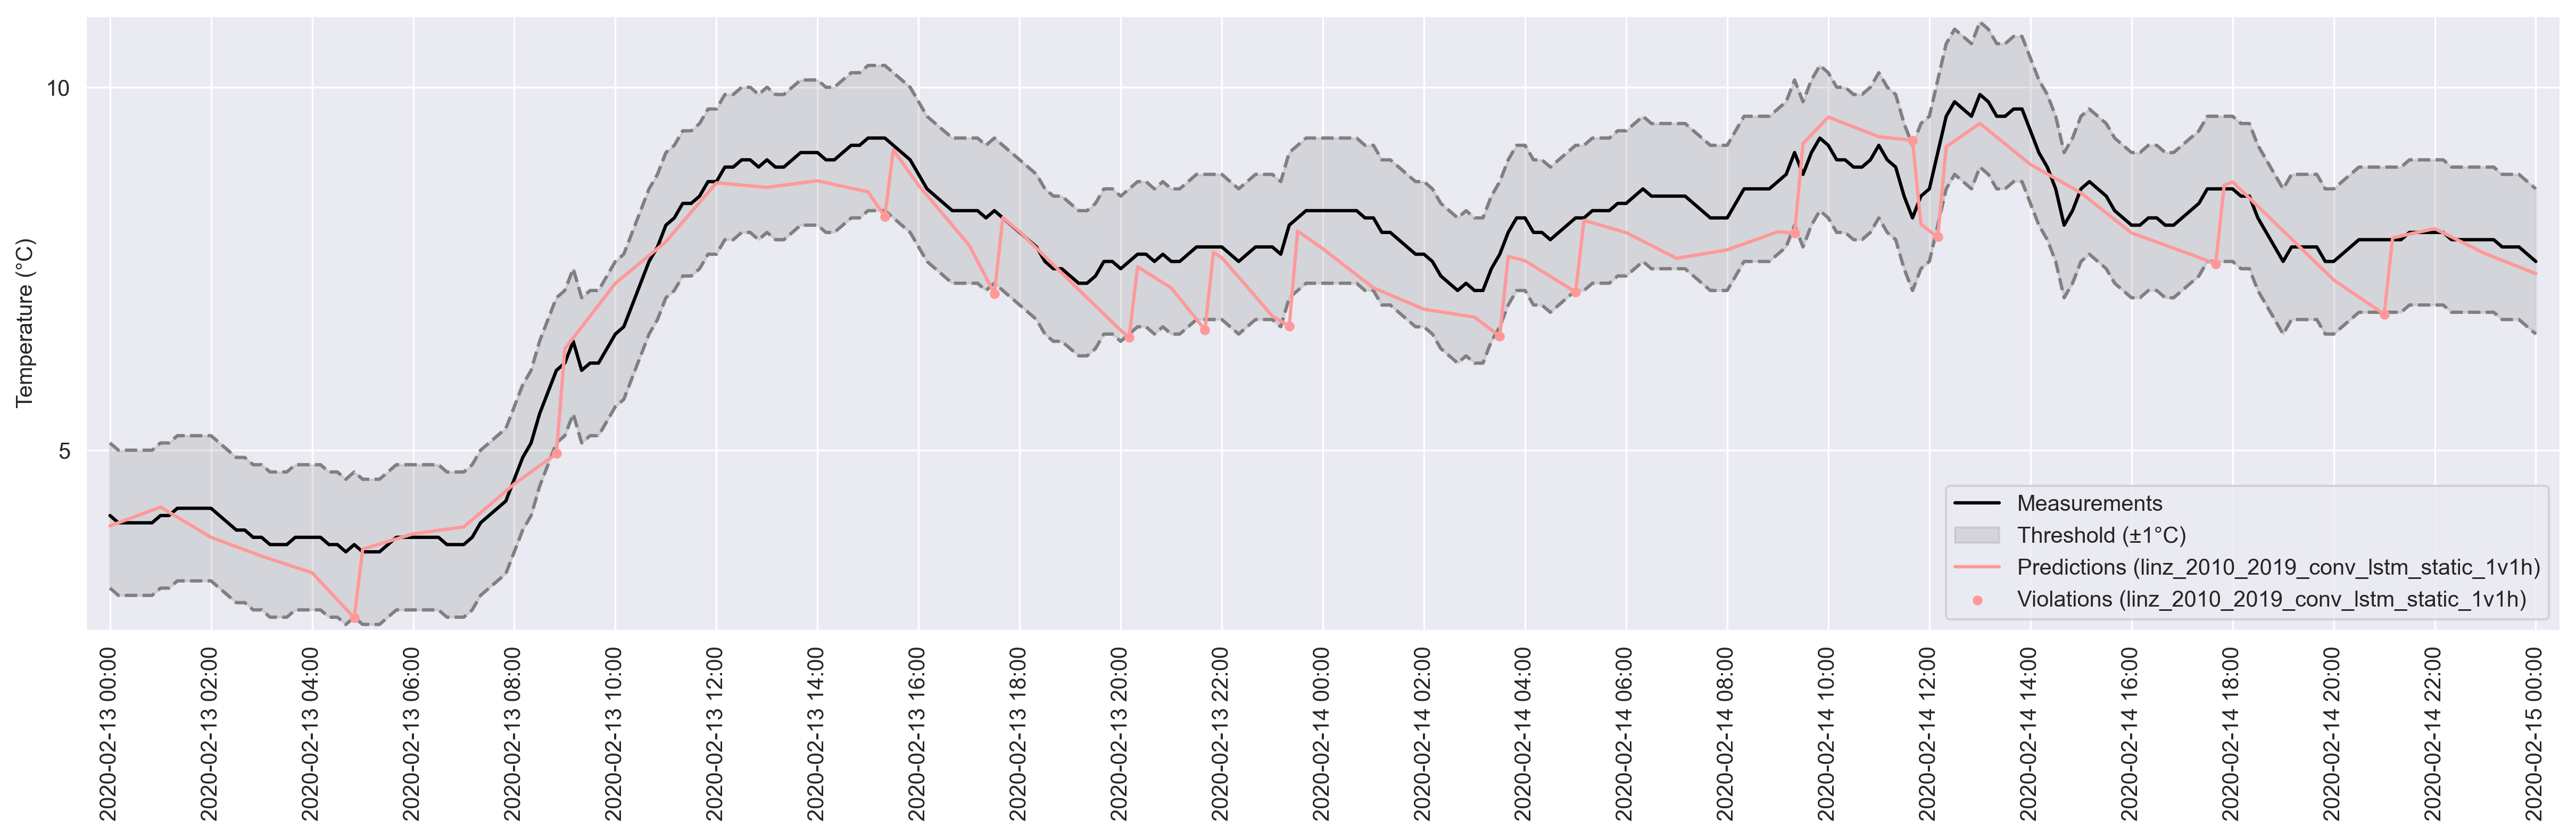

In [49]:
plot_simulations(
    start_date=anomaly_start_date,
    end_date=anomaly_end_date,
    measurements=measurements,
    simulations=[conv_lstm],
    threshold=1,
    name="conv_lstm_anomaly"
)

linz_2010_2019_simple_dense_static_1v1h=15/5291
Total violations = 15


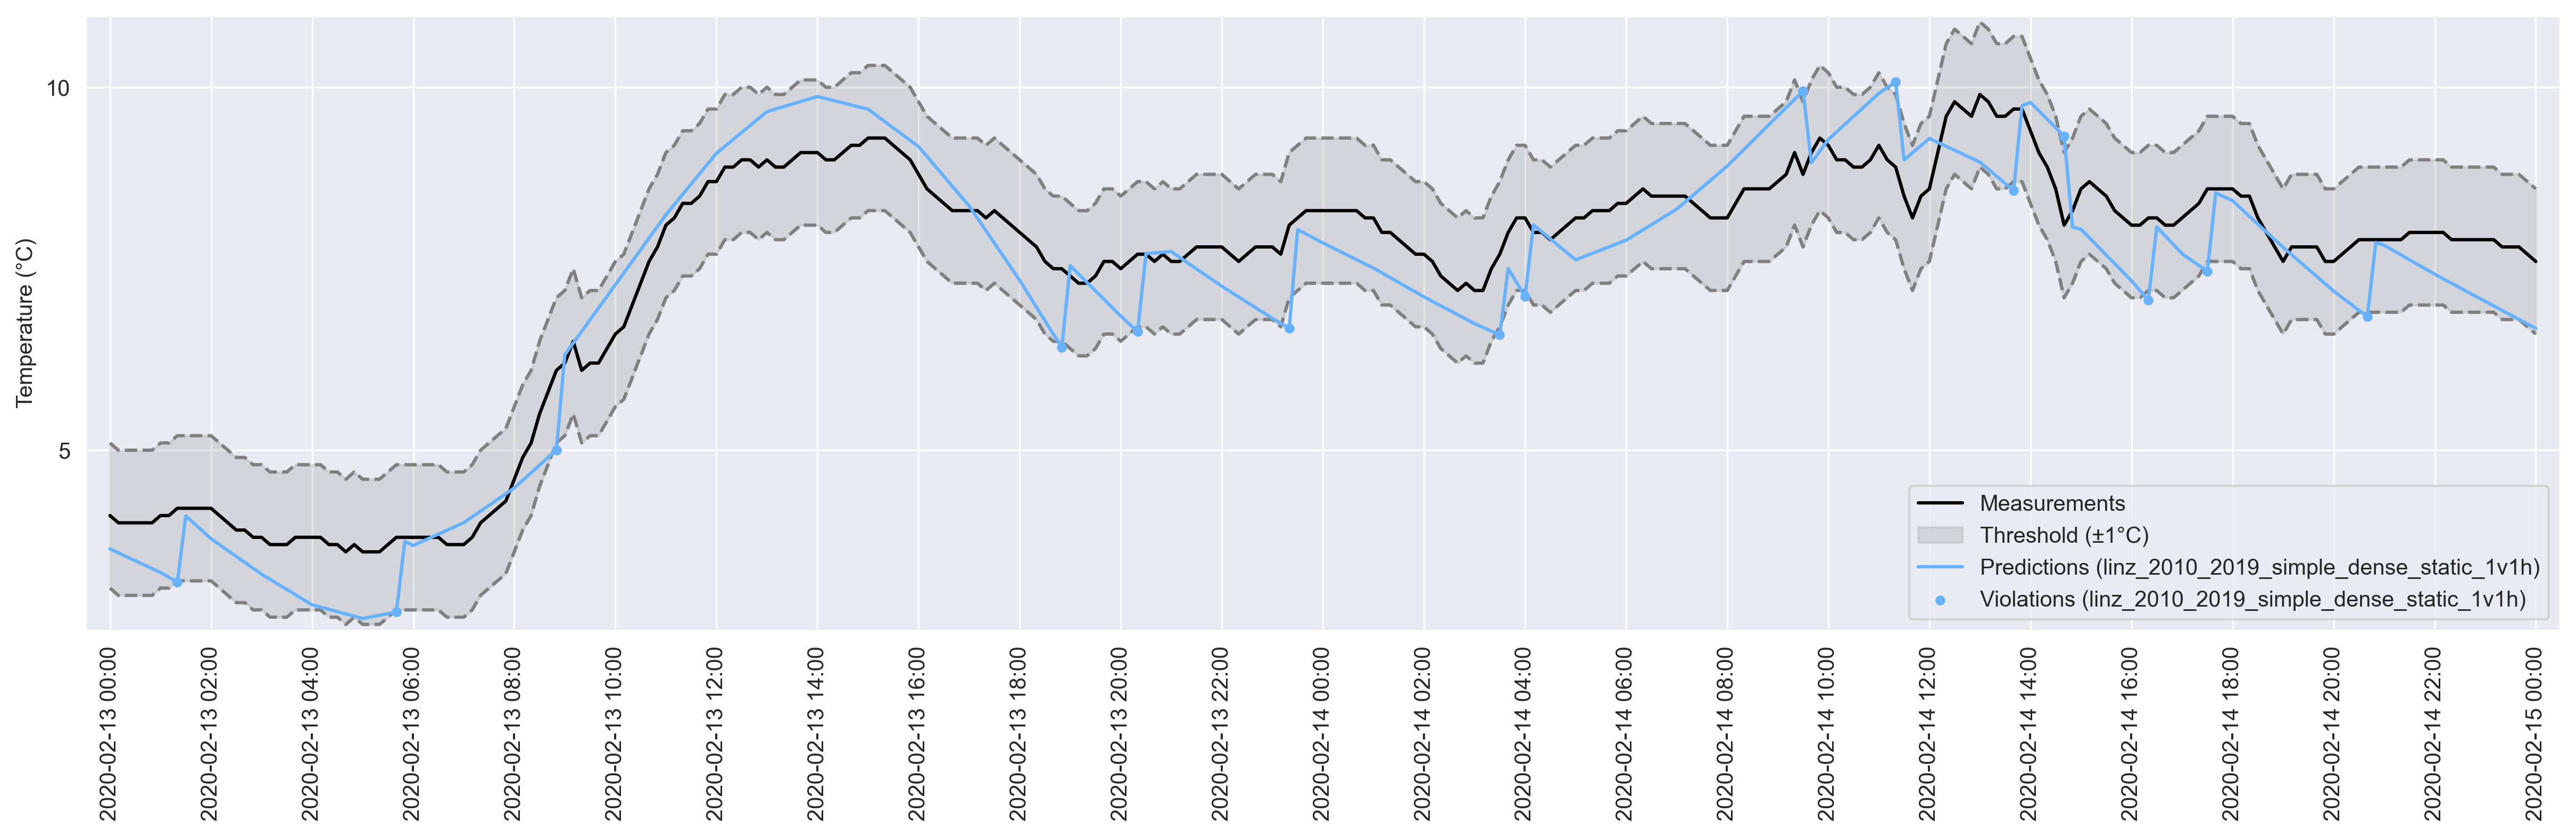

In [50]:
plot_simulations(
    start_date=anomaly_start_date,
    end_date=anomaly_end_date,
    measurements=measurements,
    simulations=[simple_dense],
    threshold=1,
    name="simple_dense_anomaly"
)

zamg_linz_2010_2019_conv_lstm=2/5
zamg_linz_2010_2019_conv_lstm=3/5
zamg_linz_2010_2019_simple_dense=4/6
zamg_linz_2010_2019_simple_dense=2/6
zamg_linz_2010_2019_simple_lstm=3/3
Total violations = 10


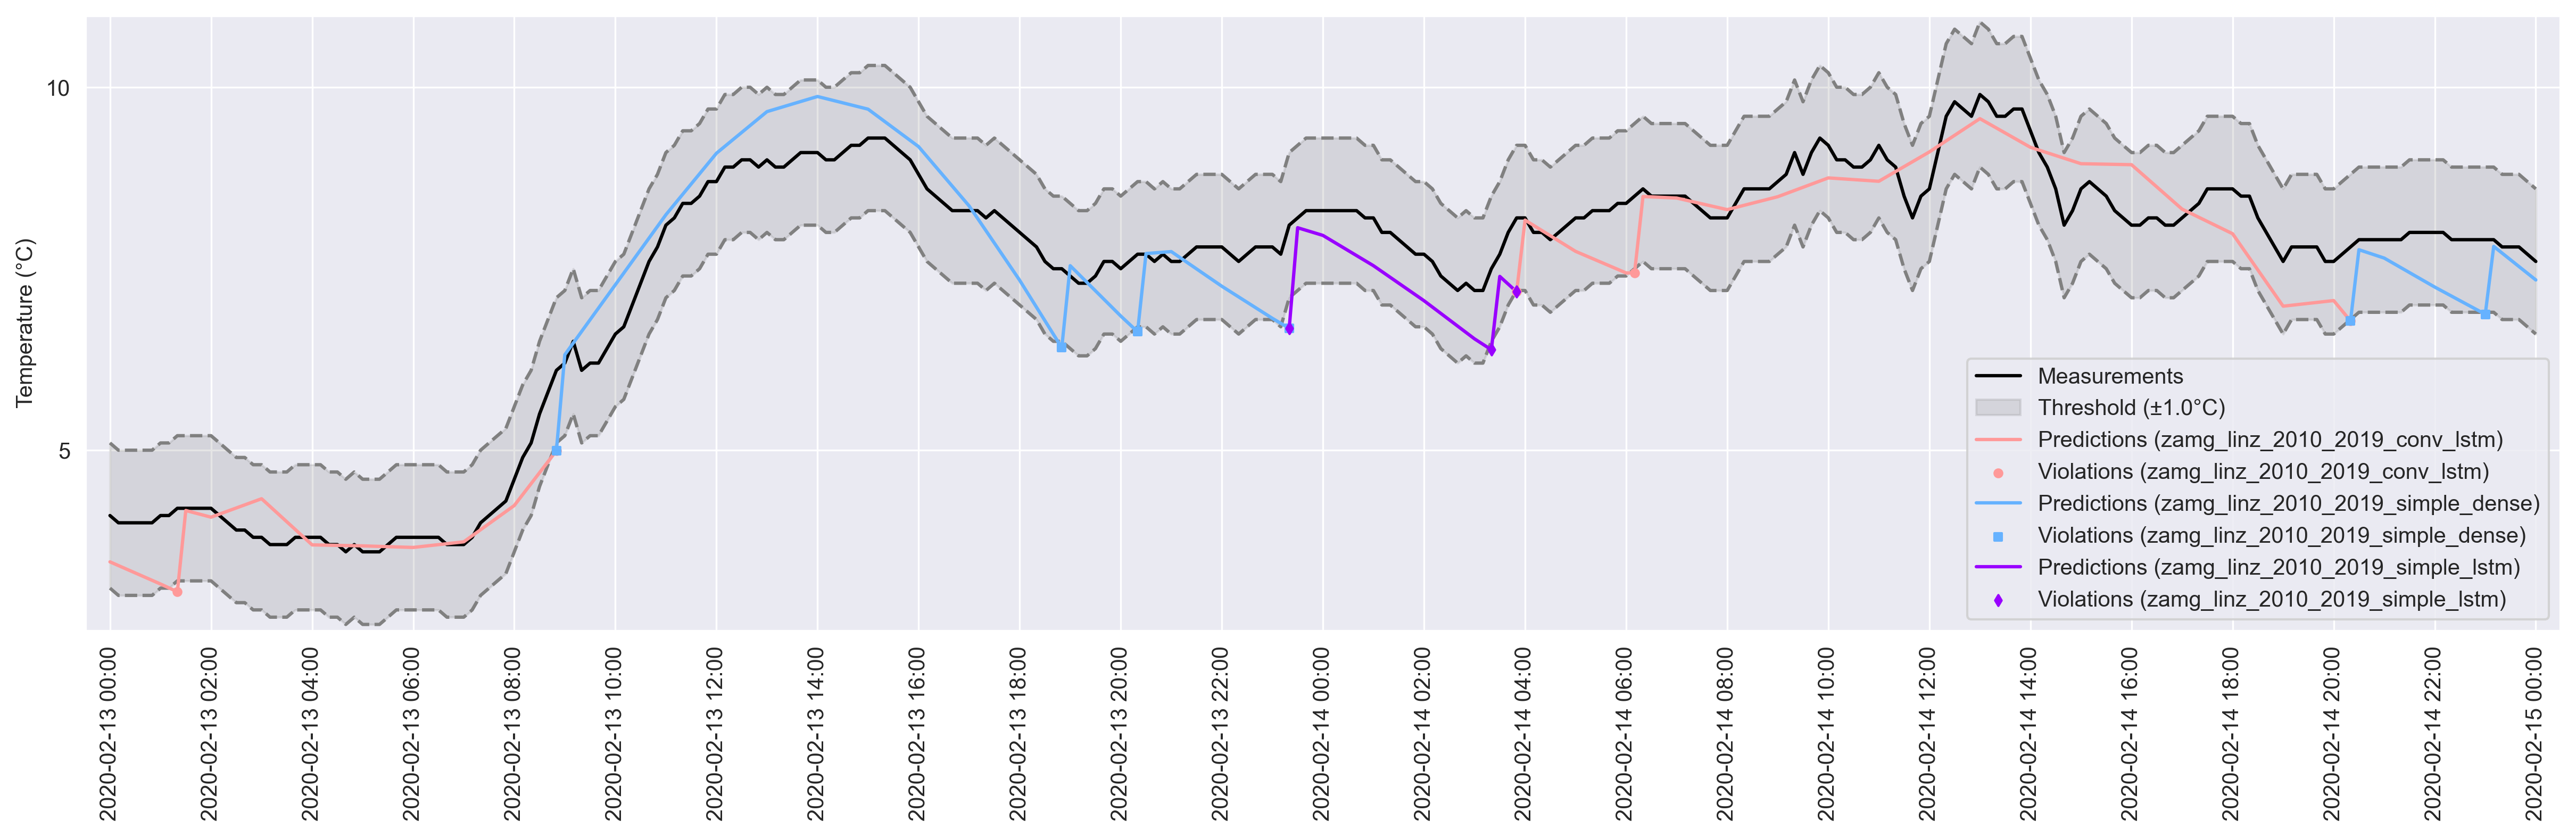

In [51]:
predictions = pd.read_csv("simulations/linz_2010_2019_mixed_arch_static_1v1h/predictions.csv", parse_dates=True,
                          index_col=0)
violations = pd.read_csv("simulations/linz_2010_2019_mixed_arch_static_1v1h/violations.csv", parse_dates=True,
                         index_col=0)
model_switches = pd.read_csv("simulations/linz_2010_2019_mixed_arch_static_1v1h/config_updates.csv", parse_dates=True,
                             index_col=0)

mixed_arch_models_intervals = calculate_intervals(model_switches, anomaly_start_date, anomaly_end_date)

i = 0
simulations: list[Simulation] = []

for model in mixed_arch_models_intervals.keys():
    p = [predictions.loc[start:end] for start, end in mixed_arch_models_intervals[model]]
    filtered_pred = pd.concat(p)
    v = [violations.loc[start:end] for start, end in mixed_arch_models_intervals[model]]
    filtered_viol = pd.concat(v)
    s = Simulation(
        name=model, predictions=filtered_pred, violations=filtered_viol, color=colors[i],
        intervals=mixed_arch_models_intervals[model]
    )
    simulations.append(s)
    i += 1

plot_simulations(
    start_date=anomaly_start_date, end_date=anomaly_end_date,
    measurements=measurements, simulations=simulations, threshold=1.0,
    name="mixed_arch_anomaly"
)

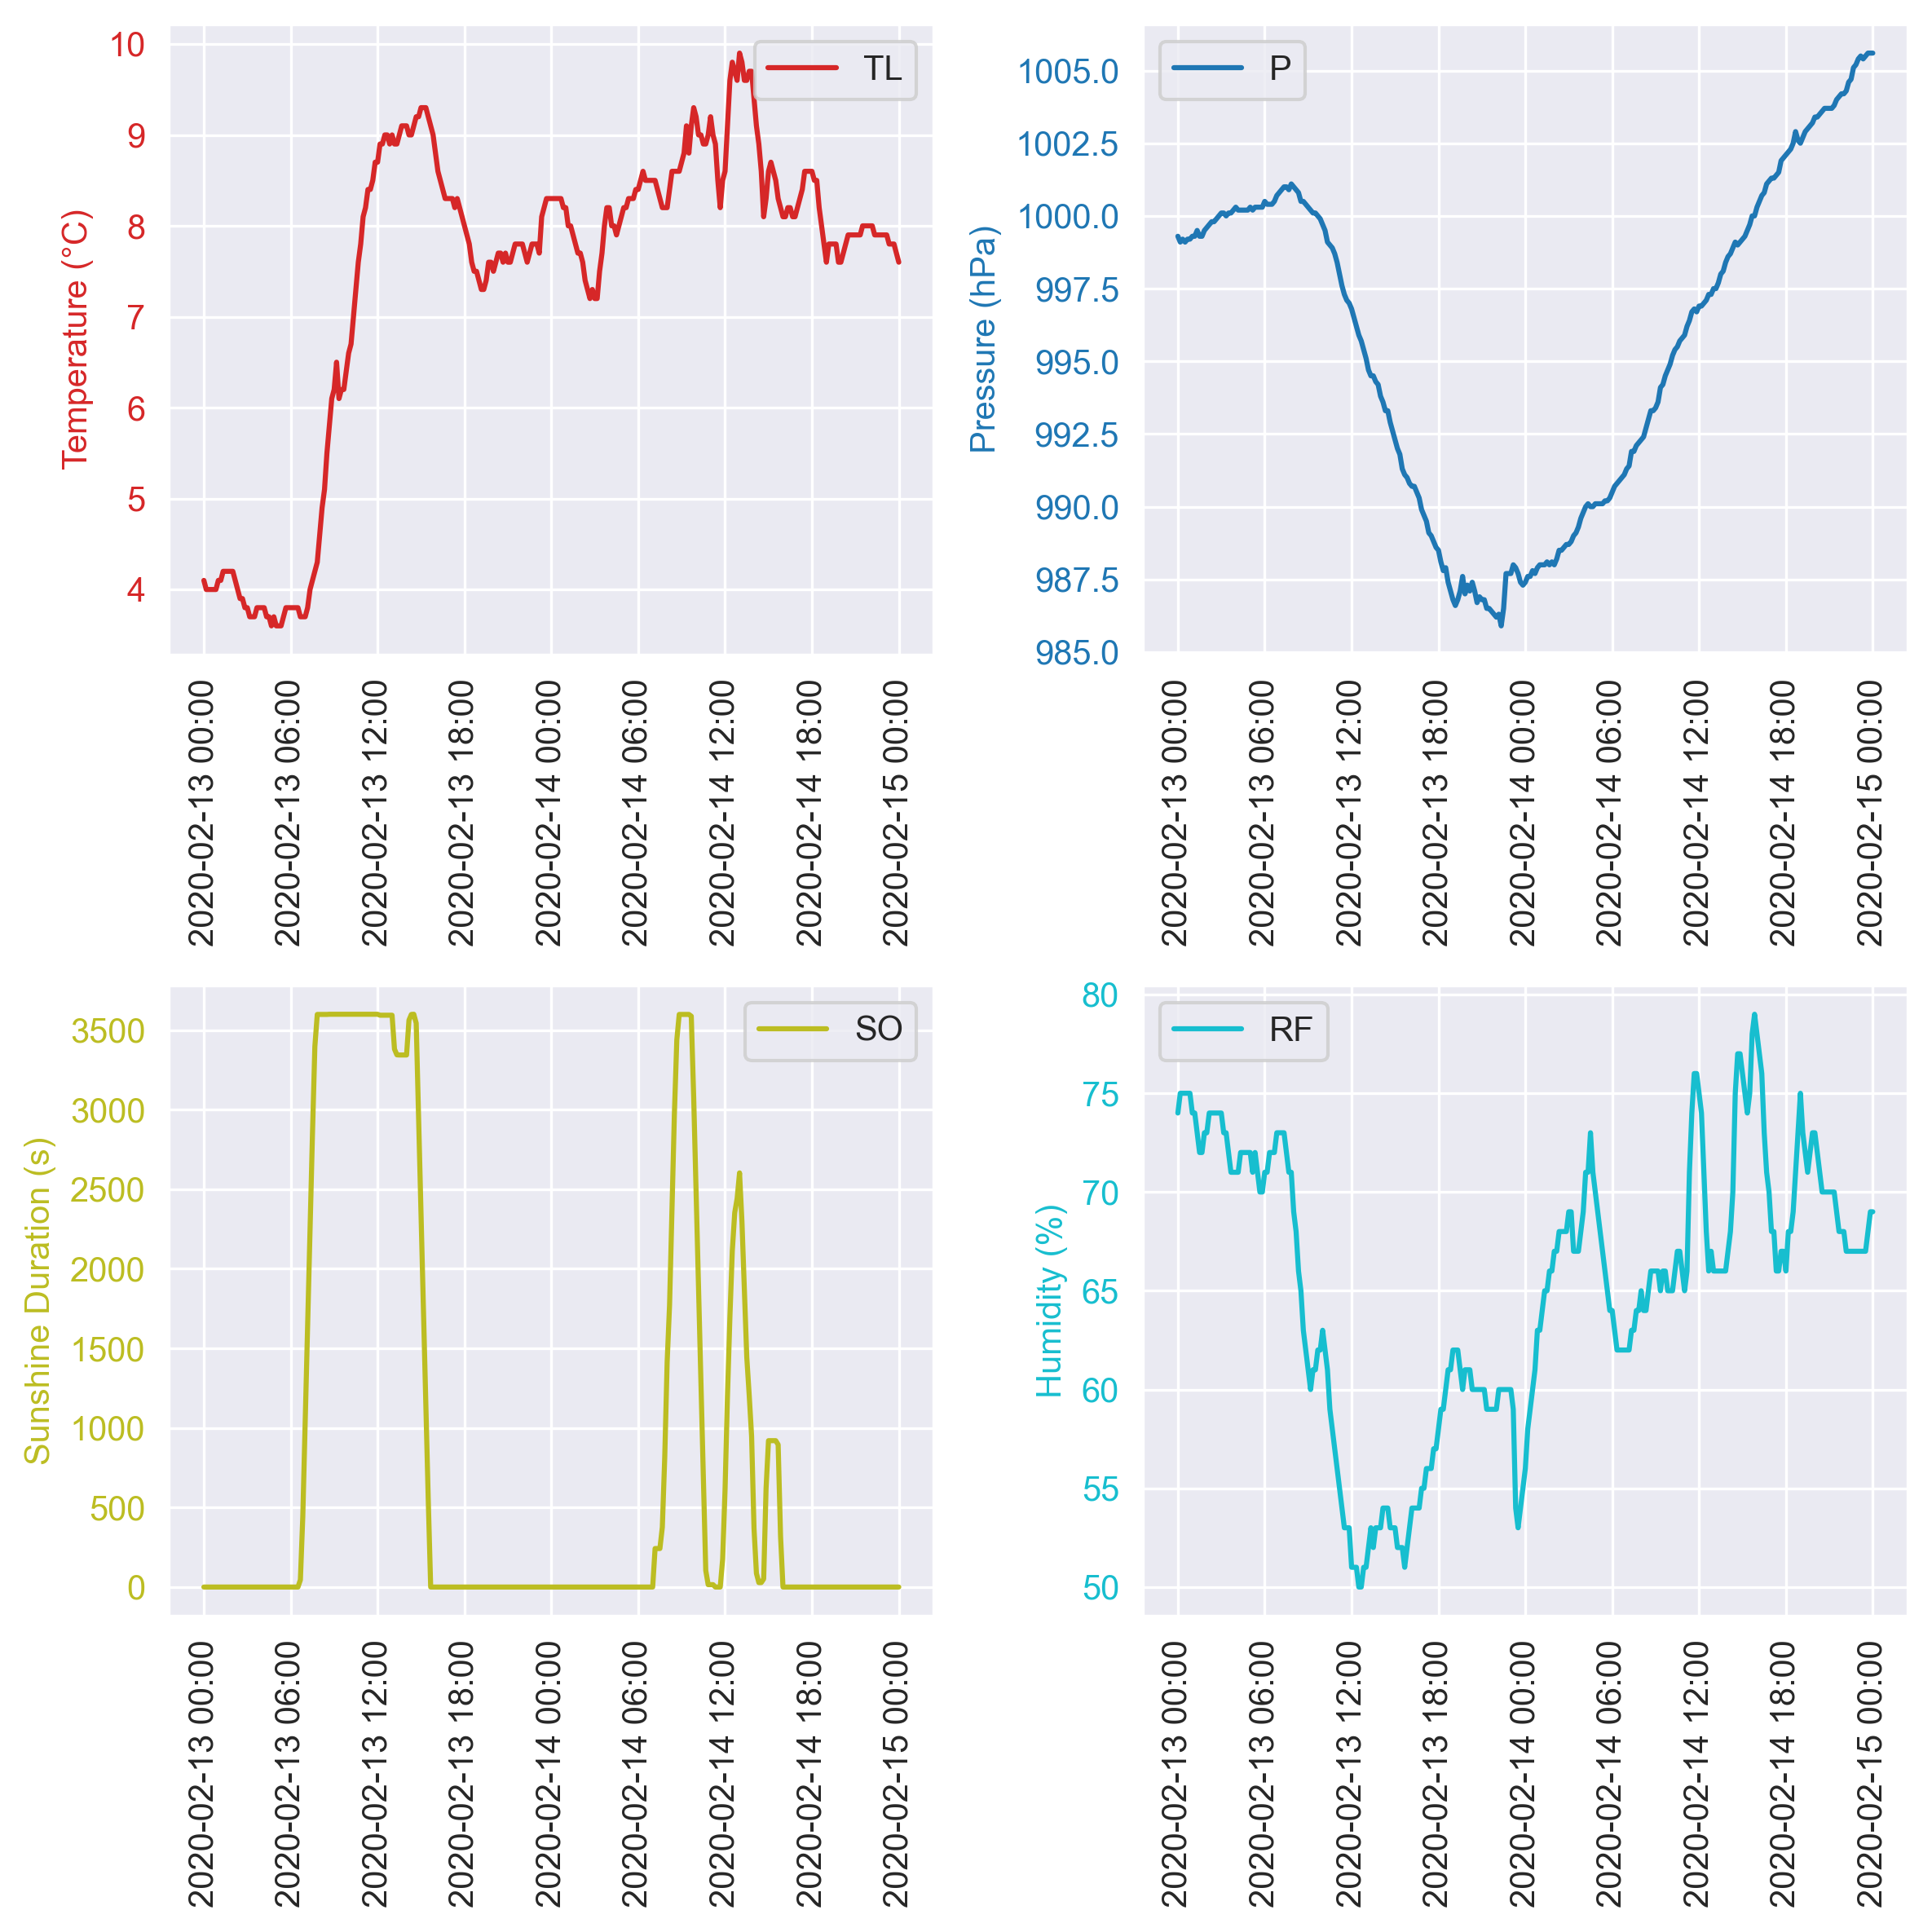

In [52]:
def plot_measurements(
        name: str,
        measurements: pd.DataFrame,
        start_date: pd.Timestamp,
        end_date: pd.Timestamp,
):
    fig, plots = plt.subplots(
        ncols=2, nrows=2,
        figsize=(8, 8),
        dpi=300
    )

    def plot_dimension(
            row: int,
            column: int,
            y_column: str,
            y_label: str,
            color: str
    ):
        plots[row, column].plot(data.index, data[y_column], color=color, label=y_column)
        plots[row, column].tick_params(axis='y', labelcolor=color)
        plots[row, column].set_ylabel(y_label, color=color)
        plots[row, column].grid(True)
        plots[row, column].legend(loc='best')
        plots[row, column].tick_params(axis='x', rotation=90)
        plots[row, column].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

    data: pd.DataFrame = measurements[start_date:end_date]

    plot_dimension(
        row=0, column=0,
        y_column='TL',
        y_label='Temperature (°C)',
        color='tab:red'
    )

    plot_dimension(
        row=0, column=1,
        y_column='P',
        y_label='Pressure (hPa)',
        color='tab:blue'
    )

    plot_dimension(
        row=1, column=0,
        y_column='SO',
        y_label='Sunshine Duration (s)',
        color='tab:olive'
    )

    plot_dimension(
        row=1, column=1,
        y_column='RF',
        y_label='Humidity (%)',
        color='tab:cyan'
    )

    plt.tight_layout()

    file_path = os.path.join("analysis", "charts", "plots", f"{name}.png")
    fig.savefig(file_path, format='png', bbox_inches='tight')
    plt.show()
    plt.close()


plot_measurements(
    name="measurements",
    measurements=measurements,
    start_date=anomaly_start_date,
    end_date=anomaly_end_date,
)